# Chido

Also look at Freddy.

In [1]:
# General
import os
import glob

# Display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

# Data treatment
import xarray as xr
import numpy as np
# from scipy.interpolate import griddata
from scipy.optimize import curve_fit
import pandas as pd 
from tqdm.notebook import tqdm
import ephem

# Default parameters
fontsize = 16
mpl.rcParams.update({'font.size': fontsize})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### Paths & Params
PRMS = {
    'ibt_vars2keep':    ['usa_lon', 'usa_lat', 'usa_pres', 'usa_wind', 'usa_r34', 'usa_r50', 'usa_r64', 'usa_rmw', 'storm_speed', 'storm_dir', 'name', 'sid'],
    'ibt_info2keep':    ['sid', 'basin', 'name', 'usa_atcf_id', 'usa_agency', 'iso_time', 'usa_status'],
}

PTHS = {
    'sar_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_UC_DIAGNOSTIC/Chido/',
    'ibt_pth': '/home/arthur/data/tropical_cyclones/ibtracs/24032025/IBTrACS.ALL.v04r01.nc',
}

### Open data
# SAR
dsg        = xr.open_dataset(PTHS['sar_pth'])

# IBTrACS
ds_ibt_all = xr.open_dataset(PTHS['ibt_pth'])
# Select variables
ds_ibt                        = ds_ibt_all[PRMS['ibt_vars2keep']]
ds_ibt[PRMS['ibt_info2keep']] = ds_ibt_all[PRMS['ibt_info2keep']].astype(str, copy=False) # Convert byte arrays to strings
# Select dates
start_date                    = np.datetime64('2009-01-01')
fsi                           = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - start_date)) # First storm index
ds_ibt                        = ds_ibt.isel(storm=slice(fsi, None))
# Convert to m/s and m units
for speed in ['usa_wind', 'storm_speed']:
    ds_ibt[speed]  *= 0.5144
for radius in ['usa_r34', 'usa_r50', 'usa_r64', 'usa_rmw']:
    ds_ibt[radius] *= 1852
# Add mean radii
# Non-zero average!!
ds_ibt['mean_r34'] = xr.where(ds_ibt.usa_r34 != 0, ds_ibt.usa_r34, np.nan).mean(dim='quadrant', skipna=True)
ds_ibt['mean_r50'] = xr.where(ds_ibt.usa_r50 != 0, ds_ibt.usa_r50, np.nan).mean(dim='quadrant', skipna=True)
ds_ibt['mean_r64'] = xr.where(ds_ibt.usa_r64 != 0, ds_ibt.usa_r64, np.nan).mean(dim='quadrant', skipna=True)
# Intensification and growing rates in IBTrACS
ds_ibt['vmx_smth']       = ds_ibt.usa_wind.rolling(date_time=4, center=True, min_periods=2).mean()
ds_ibt['r34_smth']       = ds_ibt.mean_r34.rolling(date_time=4, center=True, min_periods=2).mean()
ds_ibt['vmx_dot_smth']   = ds_ibt.vmx_smth.differentiate(coord='date_time') / 3 # m/s/hr
ds_ibt['r34_dot_smth']   = ds_ibt.r34_smth.differentiate(coord='date_time') / 3 # km/hr
# ==> Add LMI values
new                      = ds_ibt.fillna(-9999)
idx_lmi                  = new.vmx_smth.argmax(dim='date_time')
# LMI
ds_ibt['lmi']            = ds_ibt.usa_wind[:, idx_lmi]
ds_ibt['t_lmi']          = ds_ibt.time[:, idx_lmi]
# time since LMI
dt                       = (ds_ibt.time - ds_ibt.t_lmi)
dt_scds                  = dt.dt.days * 24 * 3600 + dt.dt.seconds # Nb of days + Nb of seconds (>= 0 and less than 1 day) for each element
ds_ibt['t_since_lmi']    = dt_scds # in seconds

In [3]:
### Choose ID
atcf_id = 'sh042025'

In [4]:
# GROUP BY BASIN
dsg['basin_idx'] = dsg.vmx.copy(deep=True) * np.nan
# basin_keys       = np.unique(dsg.basin)
basin_keys       = np.array(['al', 'cp', 'ep', 'wp', 'io', 'sh']) # Same order like Chavas et al 2016
for t in tqdm(range(len(dsg.time))):
    dsg['basin_idx'][t] = np.where(basin_keys == dsg.isel(time=t).basin.item())[0][0] + 1
basin_keys_combined = np.concatenate((['all'], basin_keys))

  0%|          | 0/1666 [00:00<?, ?it/s]

In [5]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20)
)
d    = dsg.where(cond, drop=True)
print(len(d.time))

640


In [6]:
# ### Colormap
# # Pour le segment négatif (-72 à 0)
# color_start_neg = 'black'           # Couleur à -72
# color_end_neg   = 'darkgoldenrod' # Couleur à 0 (côté négatif)

# # Pour le segment positif (0 à 72)
# color_start_pos = 'burlywood'          # Couleur à 0 (côté positif)
# color_end_pos   = 'crimson'        # Violet (couleur choisie pour l'exemple : 'blueviolet')

# # --- 2. Créer les deux segments de colormap ---
# # Segment pour les valeurs négatives : de noir à marron clair
# # N=128 pour avoir suffisamment de points d'échantillonnage pour un dégradé lisse
# cmap_neg_segment = mcolors.LinearSegmentedColormap.from_list(
#     'neg_part_cmap', [color_start_neg, color_end_neg], N=128
# )

# # Segment pour les valeurs positives : de rouge à violet
# cmap_pos_segment = mcolors.LinearSegmentedColormap.from_list(
#     'pos_part_cmap', [color_start_pos, color_end_pos], N=128
# )

# # --- 3. Combiner les deux segments en une seule colormap ---
# # Nous échantillonnons chaque segment et les empilons.
# # Le nombre total de couleurs N=256 est standard pour une bonne résolution.
# combined_colors = np.vstack((
#     cmap_neg_segment(np.linspace(0, 1, 128)), # Échantillonne le segment négatif
#     cmap_pos_segment(np.linspace(0, 1, 128))  # Échantillonne le segment positif
# ))

# # Crée la colormap finale à partir des couleurs combinées
# cmap = mcolors.LinearSegmentedColormap.from_list(
#     'black_brown_red_violet_continuous', combined_colors, N=256
# )

# norm = mcolors.TwoSlopeNorm(vmin=-72, vcenter=0, vmax=72)
# cmap

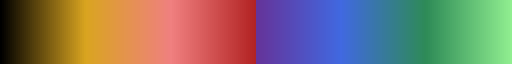

In [7]:
### Colormap

# Définition des limites de la plage totale
vmin = -72
vmax = 72

# Segment 1: -72 à -48
color_neg_72 = 'black'
color_neg_48 = 'goldenrod' 

# Segment 2: -48 à -24
color_neg_24 = 'lightcoral' 

# Segment 3: -24 à 0
color_zero_neg_side = 'firebrick' 

# Segment 4: 0 à 24
color_zero_pos_side = 'rebeccapurple' 

# Segment 5: 24 à 48
color_pos_24 = 'royalblue'

# Segment 6: 48 à 72
color_pos_48 = 'seagreen'
color_pos_72 = 'lightgreen' 

# Fonction utilitaire pour normaliser une valeur
def normalize_value(val, vmin, vmax):
    return (val - vmin) / (vmax - vmin)

colors_and_positions = [
    # Segment 1: -72 à -48 (de noir à rouge foncé)
    (normalize_value(vmin, vmin, vmax), color_neg_72),
    (normalize_value(-48, vmin, vmax), color_neg_48),

    # Segment 2: -48 à -24 (de rouge foncé à orange)
    # Note: color_neg_48 est répété pour assurer la continuité
    (normalize_value(-48, vmin, vmax), color_neg_48), # Point de départ du segment 2
    (normalize_value(-24, vmin, vmax), color_neg_24),

    # Segment 3: -24 à 0 (d'orange à gris clair)
    (normalize_value(-24, vmin, vmax), color_neg_24), # Point de départ du segment 3
    (normalize_value(0, vmin, vmax), color_zero_neg_side),

    # Segment 4: 0 à 24 (de gris clair à bleu clair)
    (normalize_value(0, vmin, vmax), color_zero_pos_side), # Point de départ du segment 4
    (normalize_value(24, vmin, vmax), color_pos_24),

    # Segment 5: 24 à 48 (de bleu clair à vert foncé)
    (normalize_value(24, vmin, vmax), color_pos_24), # Point de départ du segment 5
    (normalize_value(48, vmin, vmax), color_pos_48),

    # Segment 6: 48 à 72 (de vert foncé à violet à jaune vif)
    (normalize_value(48, vmin, vmax), color_pos_48), # Point de départ du segment 6
    (normalize_value(vmax, vmin, vmax), color_pos_72),
]

cmap_points = [
    (normalize_value(vmin, vmin, vmax), color_neg_72),
    (normalize_value(-48, vmin, vmax), color_neg_48),
    (normalize_value(-24, vmin, vmax), color_neg_24),
    (normalize_value(0, vmin, vmax), color_zero_neg_side), # Couleur à 0 pour les négatifs
    (normalize_value(0, vmin, vmax), color_zero_pos_side), # Couleur à 0 pour les positifs (pour une transition nette si désirée)
    (normalize_value(24, vmin, vmax), color_pos_24),
    (normalize_value(48, vmin, vmax), color_pos_48),
    (normalize_value(vmax, vmin, vmax), color_pos_72)
]

cmap = mcolors.LinearSegmentedColormap.from_list("custom_multi_segment_cmap", cmap_points)

# Pour la normalisation, TwoSlopeNorm est toujours appropriée si 0 est votre centre de pivot
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

cmap

In [8]:
### Select case
# SAR
ds  = d.where(d.id == atcf_id, drop=True)
# BTK
dsi = ds_ibt.where(ds_ibt.usa_atcf_id == atcf_id.upper(), drop=True).isel(storm=0)
dsi = dsi.where(((dsi.t_since_lmi / 3600) >= -72) & ((dsi.t_since_lmi / 3600) <= 72), drop=True)

In [9]:
# A23 and other parameters
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def M(f, r, V):
    return r * V + 0.5 * f * (r ** 2)

def Rmax_from_M(fcor, Mmax, Vmax):
    return (Vmax / fcor) * (np.sqrt(1 + (2 * fcor * Mmax) / (Vmax ** 2)) - 1)

def correct_vmx_ibt(vmx_ibt):
    return 0.6967 * vmx_ibt + 6.1992

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

# Bounds for fitting
BDS_HOL = {
    'B':      [0.01, 3.],
    'Vmin':   [0, 50],
    'Rmax':   [5 * 1000, 500 * 1000],
    'Vmax':   [10, 100],   
}

# Basics
dsi['vmx_reg'] = correct_vmx_ibt(dsi['usa_wind'])
dsi['fcr']     = abs(coriolis(dsi['usa_lat']))

# Rmax A23
# Compute the momentum ratios
Mm_M34 = 0.531 * np.exp(
    -0.00214 * (dsi['vmx_reg'] - 17.5)
    -0.00314 * (dsi['vmx_reg'] - 17.5) * 0.5 * dsi['fcr'] * dsi['mean_r34']
)
Mm_M50 = 0.626 * np.exp(
     0.00282 * (dsi['vmx_reg'] - 25.7)
    -0.00724 * (dsi['vmx_reg'] - 25.7) * 0.5 * dsi['fcr'] * dsi['mean_r50']
)
Mm_M64 = 0.612 * np.exp(
     0.00946 * (dsi['vmx_reg'] - 32.9)
    -0.01183 * (dsi['vmx_reg'] - 32.9) * 0.5 * dsi['fcr'] * dsi['mean_r64']
)
# Compute Mmax
Mm_with_r34 = Mm_M34 * M(dsi['fcr'], dsi['mean_r34'], 17.5)
Mm_with_r50 = Mm_M50 * M(dsi['fcr'], dsi['mean_r50'], 25.7)
Mm_with_r64 = Mm_M64 * M(dsi['fcr'], dsi['mean_r64'], 32.9)
# Compute Rmax_CK22A23
Rm_with_r34 = Rmax_from_M(dsi['fcr'], Mm_with_r34, dsi['vmx_reg'])
Rm_with_r50 = Rmax_from_M(dsi['fcr'], Mm_with_r50, dsi['vmx_reg'])
Rm_with_r64 = Rmax_from_M(dsi['fcr'], Mm_with_r64, dsi['vmx_reg'])
# Assign to your dataset
dsi['new_rmx'] = Rm_with_r34.copy(deep=True)
dsi['new_rmx'][Rm_with_r50.notnull()] = Rm_with_r50.copy(deep=True)[Rm_with_r50.notnull()]
dsi['new_rmx'][Rm_with_r64.notnull()] = Rm_with_r64.copy(deep=True)[Rm_with_r64.notnull()]

# Others
dsi['rsb']     = dsi['usa_wind'] / (abs(dsi['fcr']) * dsi['usa_rmw'])
dsi['r0']      = np.sqrt(2 * dsi['rsb']) * dsi['usa_rmw']
dsi['new_rsb'] = dsi['vmx_reg'] / (abs(dsi['fcr']) * dsi['new_rmx'])
dsi['new_r0']  = np.sqrt(2 * dsi['new_rsb']) * dsi['new_rmx']

In [10]:
### Add Bs, Uc, and R+

In [11]:
# Add Bs 
# Adjusts a Holland wind profile to BTK wind radii
# Only when both r34, r50 and r64 are defined to ensure minimum number of valid points
# Fitting results look bad
# NB: I tried to enforce Vmin = 10m/s (i.e average SAR ds.vmin.mean()), but this doesn't improve fittings

Bs   = []
VMNs = []
RMXs = []
VMXs = []

for dtm in tqdm(range(len(dsi.date_time))):
    # Concatenate wind radii
    rss = [float(dsi.isel(date_time=dtm)['usa_rmw']), float(dsi.isel(date_time=dtm)['mean_r64']), float(dsi.isel(date_time=dtm)['mean_r50']), float(dsi.isel(date_time=dtm)['mean_r34'])]
    wss = [float(dsi.isel(date_time=dtm)['usa_wind']), 32.9, 25.7, 17.5]

    # Fit Holland
    if np.count_nonzero(np.isnan(rss)) == 0:
        # Holland
        popt, pcov = curve_fit(
            lambda r, B, Vmin, Rmax, Vmax: holland_profile(r, abs(float(dsi.isel(date_time=dtm).usa_lat)), B, Vmin, Rmax, Vmax),
            # lambda r, B, Rmax, Vmax: holland_profile(r, float(dsi.isel(date_time=d).usa_lat), B, 10, Rmax, Vmax),
            np.array(rss), 
            np.array(wss), 
            p0=[1.8, 5, 20 * 1000, 40], 
            # p0=[1.8, 20 * 1000, 40],
            bounds=(
                tuple([BDS_HOL[e][0] for e in BDS_HOL.keys()]), # NB: lat is fixed
                tuple([BDS_HOL[e][1] for e in BDS_HOL.keys()])
            ) 
        ) 
        B_hol, vmn_hol, rmx_hol, vmx_hol = popt
        # B_hol, rmx_hol, vmx_hol = popt
        # Plot
        plt.scatter(np.array(rss) / 1000, wss, color=cmap(norm(float(dsi.isel(date_time=dtm).t_since_lmi / 3600))), alpha=0.5)
        plt.plot(np.linspace(0, 500000, 1001) / 1000, holland_profile(np.linspace(0, 500000, 1001), float(dsi.isel(date_time=dtm).usa_lat), B_hol, vmn_hol, rmx_hol, vmx_hol), alpha=0.5)
        # plt.plot(np.linspace(0, 500000, 1001) / 1000, holland_profile(np.linspace(0, 500000, 1001), float(dsi.isel(date_time=dtm).usa_lat), B_hol, 10, rmx_hol, vmx_hol), alpha=0.5)
    else:
        B_hol = vmn_hol = rmx_hol = vmx_hol = np.nan
        # B_hol = rmx_hol = vmx_hol = np.nan
    # Append
    Bs.append(B_hol)
    VMNs.append(vmn_hol)
    RMXs.append(rmx_hol)
    VMXs.append(vmx_hol)
    
# plt.xlim(0, 250)
dsi['Bs']     = xr.DataArray(Bs, dims='date_time')
dsi['uc']     = np.sqrt(3 * np.sqrt(2) * dsi.usa_wind ** 2 / np.sqrt(dsi.Bs * dsi.rsb))
dsi['new_uc'] = np.sqrt(3 * np.sqrt(2) * dsi.vmx_reg ** 2 / np.sqrt(dsi.Bs * dsi.new_rsb))

  0%|          | 0/46 [00:00<?, ?it/s]

In [12]:
ds.isel(time=0).t_lmi_ibt

<xarray.DataArray 't_lmi_ibt' ()> Size: 8B
array('2024-12-12T09:00:00.000039936', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2024-12-10T01:40:19
Attributes:
    long_name:  Time of the lifetime maximum intensity from IBTrACS (U.S. Age...

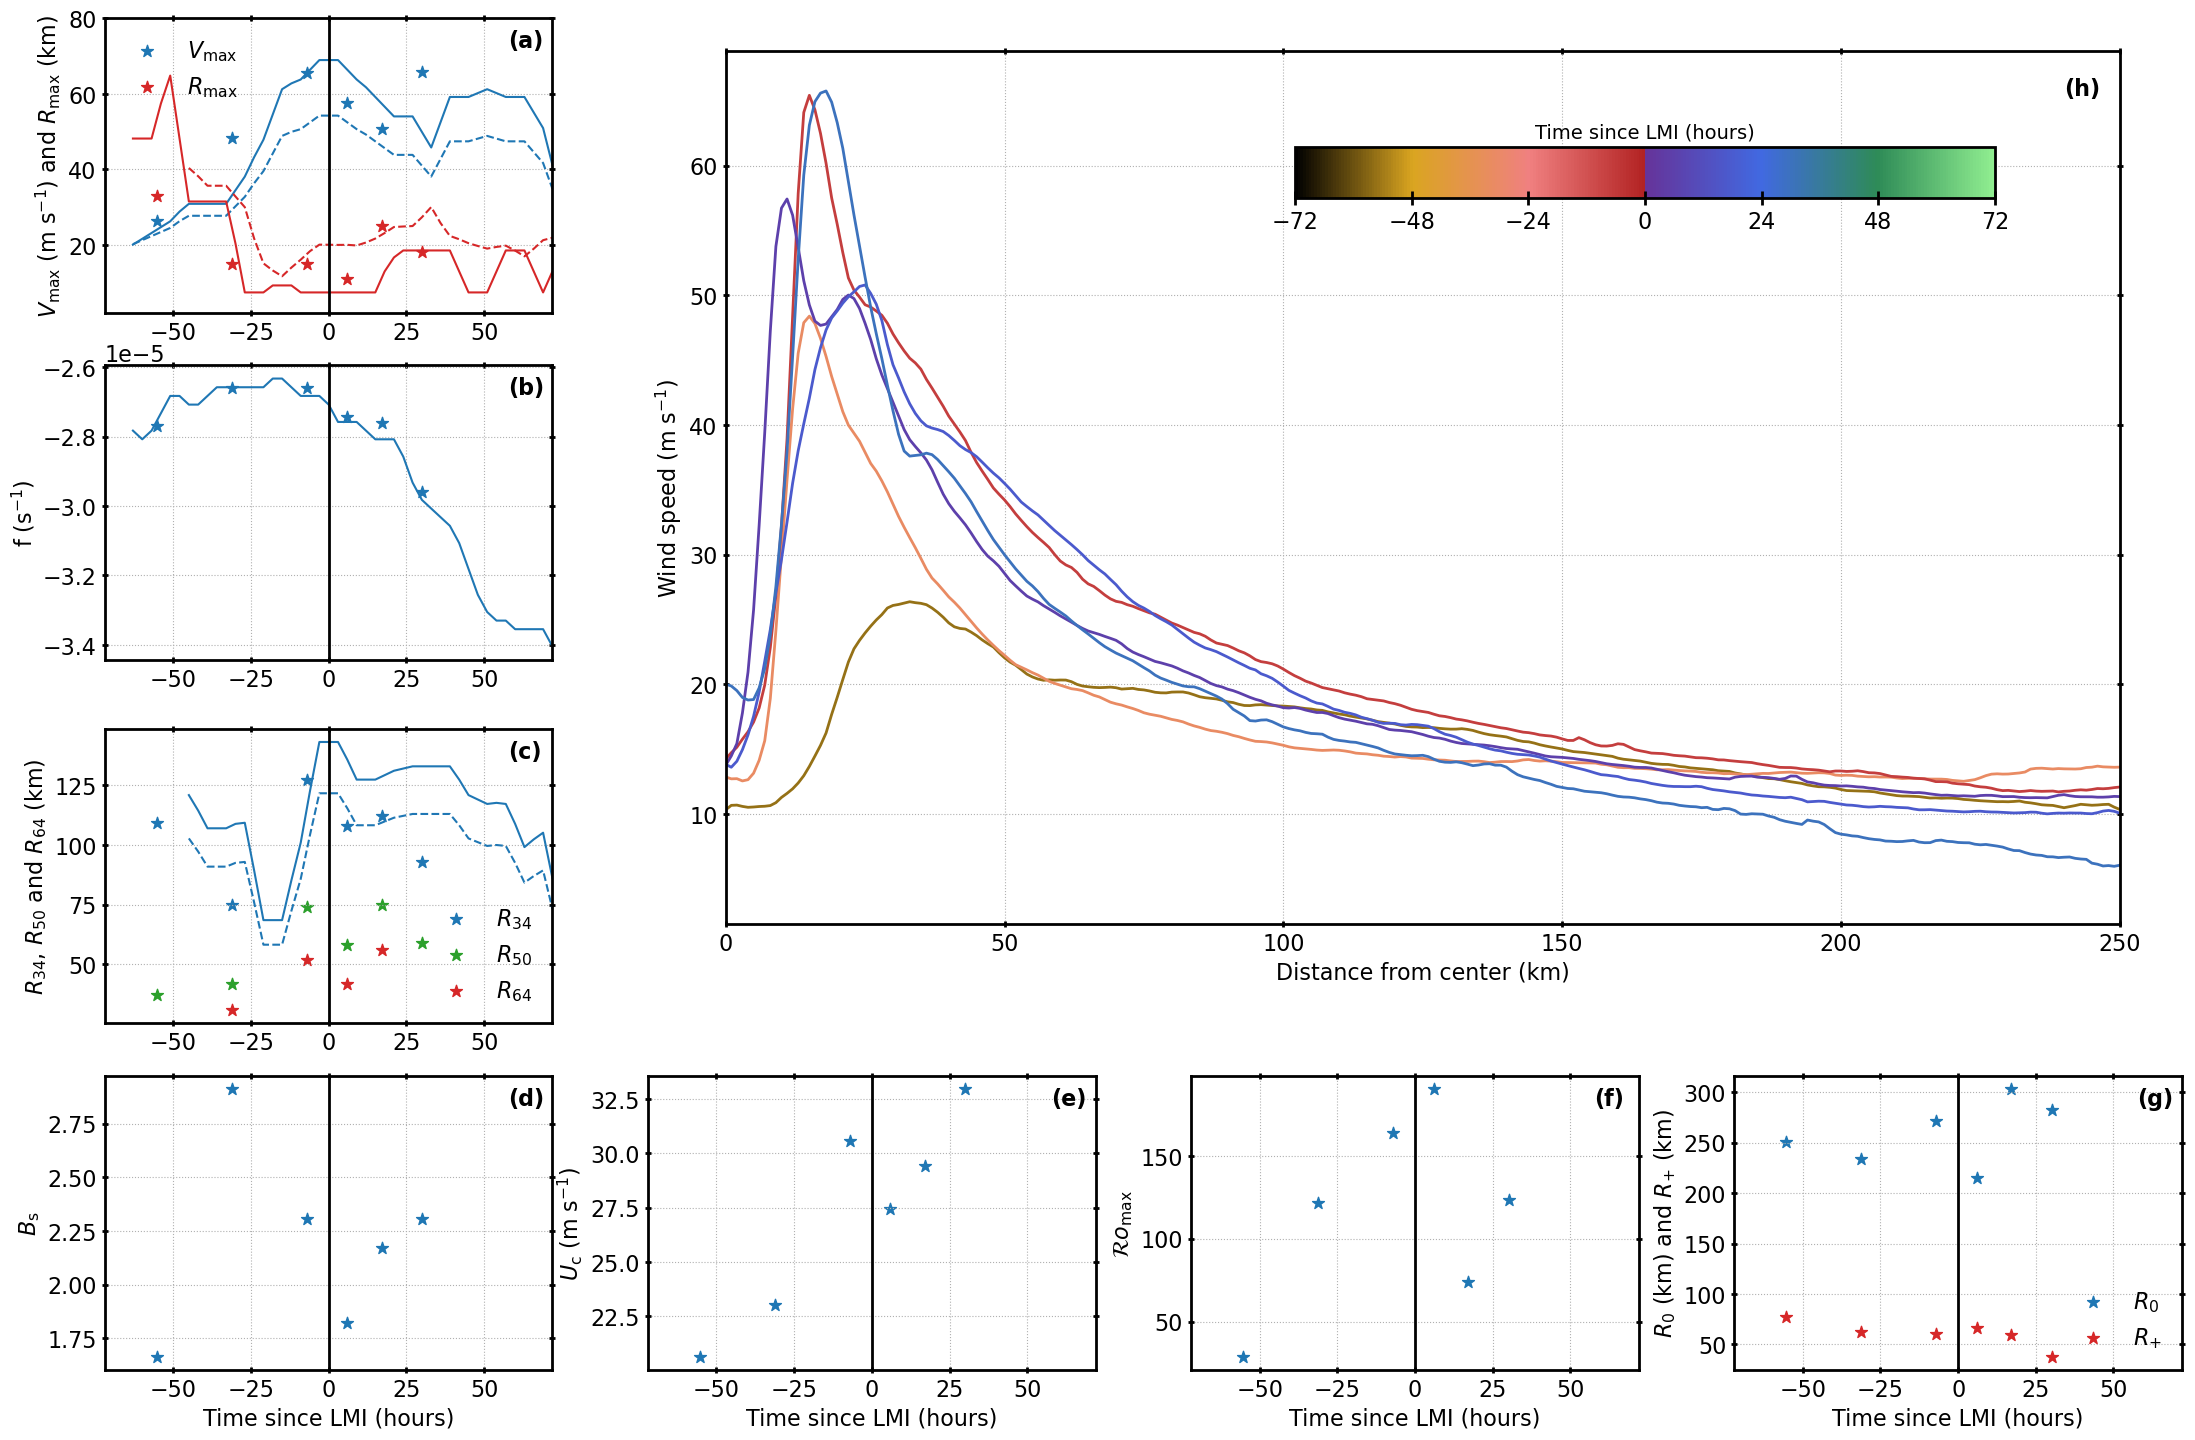

In [32]:
### Hyperparameters
ticks  = np.arange(-72, 73, 24)
ax_lim = 250


fig = plt.figure(figsize = (28, 30))

# Define the number of division, 1st vertical 2nd horizontal
# It's convenient to put a large number of division to perform smart tuning of the subplot position
gs  = GridSpec(140, 140) 

################
### PROFILES ###
################
ax = fig.add_subplot(gs[2:55, 40:130])
ax.text(0.96, 0.95, '(h)', transform=ax.transAxes, weight='bold')

for t in range(len(ds.time)):
    # Open
    dss = ds.isel(time=t)
    dsp = xr.open_dataset(PTHS['sar_dir'] + dss.file_tcva.item()).isel(time=0)
    wsm = dsp.wind_speed.mean(dim='theta')

    # Plot
    ax.plot(wsm.rad / 1000, wsm, c=cmap(norm(dss.t_since_lmi_ibt / 3600)), linewidth=2)

    # Close
    dsp.close()

# Axes
ax.set_xlim(0, ax_lim)
ax.set_ylabel(r'Wind speed (m s$^{-1}$)')
ax.set_xlabel(r'Distance from center (km)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

# Colorbar
sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.55, 0.82, 0.25, 0.017]) # Position of the colorbar (this is tricky just do tests)
cbar    = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', ticks=ticks)
cbar_ax.set_title(r'Time since LMI (hours)', fontsize=fontsize-2, x=0.5, y=1.02)
cbar.ax.yaxis.set_offset_position('right')
cbar.update_ticks()
cbar.outline.set_linewidth(2)
cbar_ax.tick_params(direction='inout', width=2, length=10, labelsize=16)

################
### RMX/VMX  ###
################
ax = fig.add_subplot(gs[:18, :29])
ax.text(0.9, 0.9, '(a)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.vmx,        marker='*', s=80, color='tab:blue', label=r'$V_{\text{max}}$')
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.rmx / 1000, marker='*', s=80, color='tab:red',  label=r'$R_{\text{max}}$')
# BTK
ax.plot(dsi.t_since_lmi / 3600,       dsi.usa_wind,                    color='tab:blue')
ax.plot(dsi.t_since_lmi / 3600,       dsi.vmx_reg,                     color='tab:blue', linestyle='dashed')
ax.plot(dsi.t_since_lmi / 3600,       dsi.usa_rmw / 1000,              color='tab:red')
ax.plot(dsi.t_since_lmi / 3600,       dsi.new_rmx / 1000,              color='tab:red', linestyle='dashed')
ax.set_ylim(2, 80)

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$V_{\text{max}}$ (m s$^{-1}$) and $R_{\text{max}}$ (km)')
# ax.set_xlabel(r'Time since LMI (hours)')
ax.legend(frameon=False)

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###   FCOR   ###
################
ax = fig.add_subplot(gs[21:39, :29])
ax.text(0.9, 0.9, '(b)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.fcor,        marker='*', s=80, color='tab:blue')
# BTK
ax.plot(dsi.t_since_lmi / 3600,       -dsi.fcr,                          color='tab:blue')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'f (s$^{-1})$')
# ax.set_xlabel(r'Time since LMI (hours)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###   Rxx    ###
################
ax = fig.add_subplot(gs[43:61, :29])
ax.text(0.9, 0.9, '(c)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.r34 / 1000, marker='*', s=80, color='tab:blue',  label=r'$R_{\text{34}}$')
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.r50 / 1000, marker='*', s=80, color='tab:green', label=r'$R_{\text{50}}$')
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.r64 / 1000, marker='*', s=80, color='tab:red',   label=r'$R_{\text{64}}$')
# BTK
ax.plot(dsi.t_since_lmi / 3600,       dsi.mean_r34 / 1000,             color='tab:blue')
ax.plot(dsi.t_since_lmi / 3600,       dsi.mean_r50 / 1000,             color='tab:green')
ax.plot(dsi.t_since_lmi / 3600,       dsi.mean_r64 / 1000,             color='tab:red')
ax.plot(dsi.t_since_lmi / 3600,       0.85 * dsi.mean_r34 / 1000,      color='tab:blue',  linestyle='dashed',)
ax.plot(dsi.t_since_lmi / 3600,       0.85 * dsi.mean_r50 / 1000,      color='tab:green', linestyle='dashed',)
ax.plot(dsi.t_since_lmi / 3600,       0.85 * dsi.mean_r64 / 1000,      color='tab:red',   linestyle='dashed',)


# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$R_{\text{34}}$, $R_{\text{50}}$ and $R_{\text{64}}$ (km)')
# ax.set_xlabel(r'Time since LMI (hours)')
ax.legend(frameon=False)

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###    Bs    ###
################
ax = fig.add_subplot(gs[64:82, :29])
ax.text(0.9, 0.9, '(d)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.B_hol, marker='*', s=80, color='tab:blue')
# # BTK
# ax.plot(dsi.t_since_lmi / 3600,    dsi.Bs,                        color='tab:blue')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$B_{\text{s}}$')
ax.set_xlabel(r'Time since LMI (hours)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###    Uc    ###
################
ax = fig.add_subplot(gs[64:82, 35:64])
ax.text(0.9, 0.9, '(e)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.uc, marker='*', s=80, color='tab:blue')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$U_{\text{c}}$ (m s$^{-1}$)')
ax.set_xlabel(r'Time since LMI (hours)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###  Rossby  ###
################
ax = fig.add_subplot(gs[64:82, 70:99])
ax.text(0.9, 0.9, '(f)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.rsby, marker='*', s=80, color='tab:blue')
# # BTK
# ax.plot(dsi.t_since_lmi / 3600,       dsi.rsb,                   color='tab:blue')
# ax.plot(dsi.t_since_lmi / 3600,       dsi.new_rsb,               color='tab:blue', linestyle='dashed')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$\mathcal{R}o_{\text{max}}$')
ax.set_xlabel(r'Time since LMI (hours)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###  R+/R0   ###
################
ax = fig.add_subplot(gs[64:82, 105:134])
ax.text(0.9, 0.9, '(g)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.r0 / 1000,  marker='*', s=80, color='tab:blue', label=r'$R_{\text{0}}$')
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.rps / 1000, marker='*', s=80, color='tab:red',  label=r'$R_{\text{+}}$')
# # BTK
# ax.plot(dsi.t_since_lmi / 3600,       dsi.r0 / 1000,                   color='tab:blue')
# ax.plot(dsi.t_since_lmi / 3600,       dsi.new_r0 / 1000,               color='tab:blue', linestyle='dashed')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$R_{\text{0}}$ (km) and $R_{\text{+}}$ (km)')
ax.set_xlabel(r'Time since LMI (hours)')
ax.legend(frameon=False)

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

# # Save
# plt.savefig(PTHS['sav_dir'] + 'chido_winds.png', bbox_inches='tight')

In [14]:
# L'épaule de Chido n'augmente pas beaucoup au début de la RI;
# Cela lui permet de maintenir un R+ très proche de Rmax malgré un Rmax assez faible
# Tout en maintenant un R0 très loin
# So the ratio R0 / R+ is very high
# According to paper 2 (GRL), the system was very unstable if it kept the same Vmax.
# Hmmm, bof.

# Low latitude compared to the rest of the database!!!
# At such low latitudes Uc is thus very weak!!
# So even if the R0/R+ ratio was in the mean, the system was unstable!!
# All things being equal (Vmax, Rmax), the latitude controls R0, which decreases with latitude. 
# Thus at low latitudes R0 is also supposed to be large (but not so much in the end, it remains in the mean of the basin all the life cycle.
# The air masses need to converge toward the center so R0 cannot be too large.
# Perhaps R0 was also constrained by the anticyclone in the southern area (Chido was also blocked by lower latitudes in the North).
# For Chido the inflow was also possibly strengthened by the warm ocean.

In [15]:
print(float((dsg.r0 / dsg.rps).mean()))
print(float((ds.isel(time=0).r0 / ds.isel(time=0).rps).mean()))
print(float((ds.isel(time=1).r0 / ds.isel(time=1).rps).mean()))

3.2948255588992845
3.2282598357685988
3.7632157235807084


In [16]:
### Ocean response

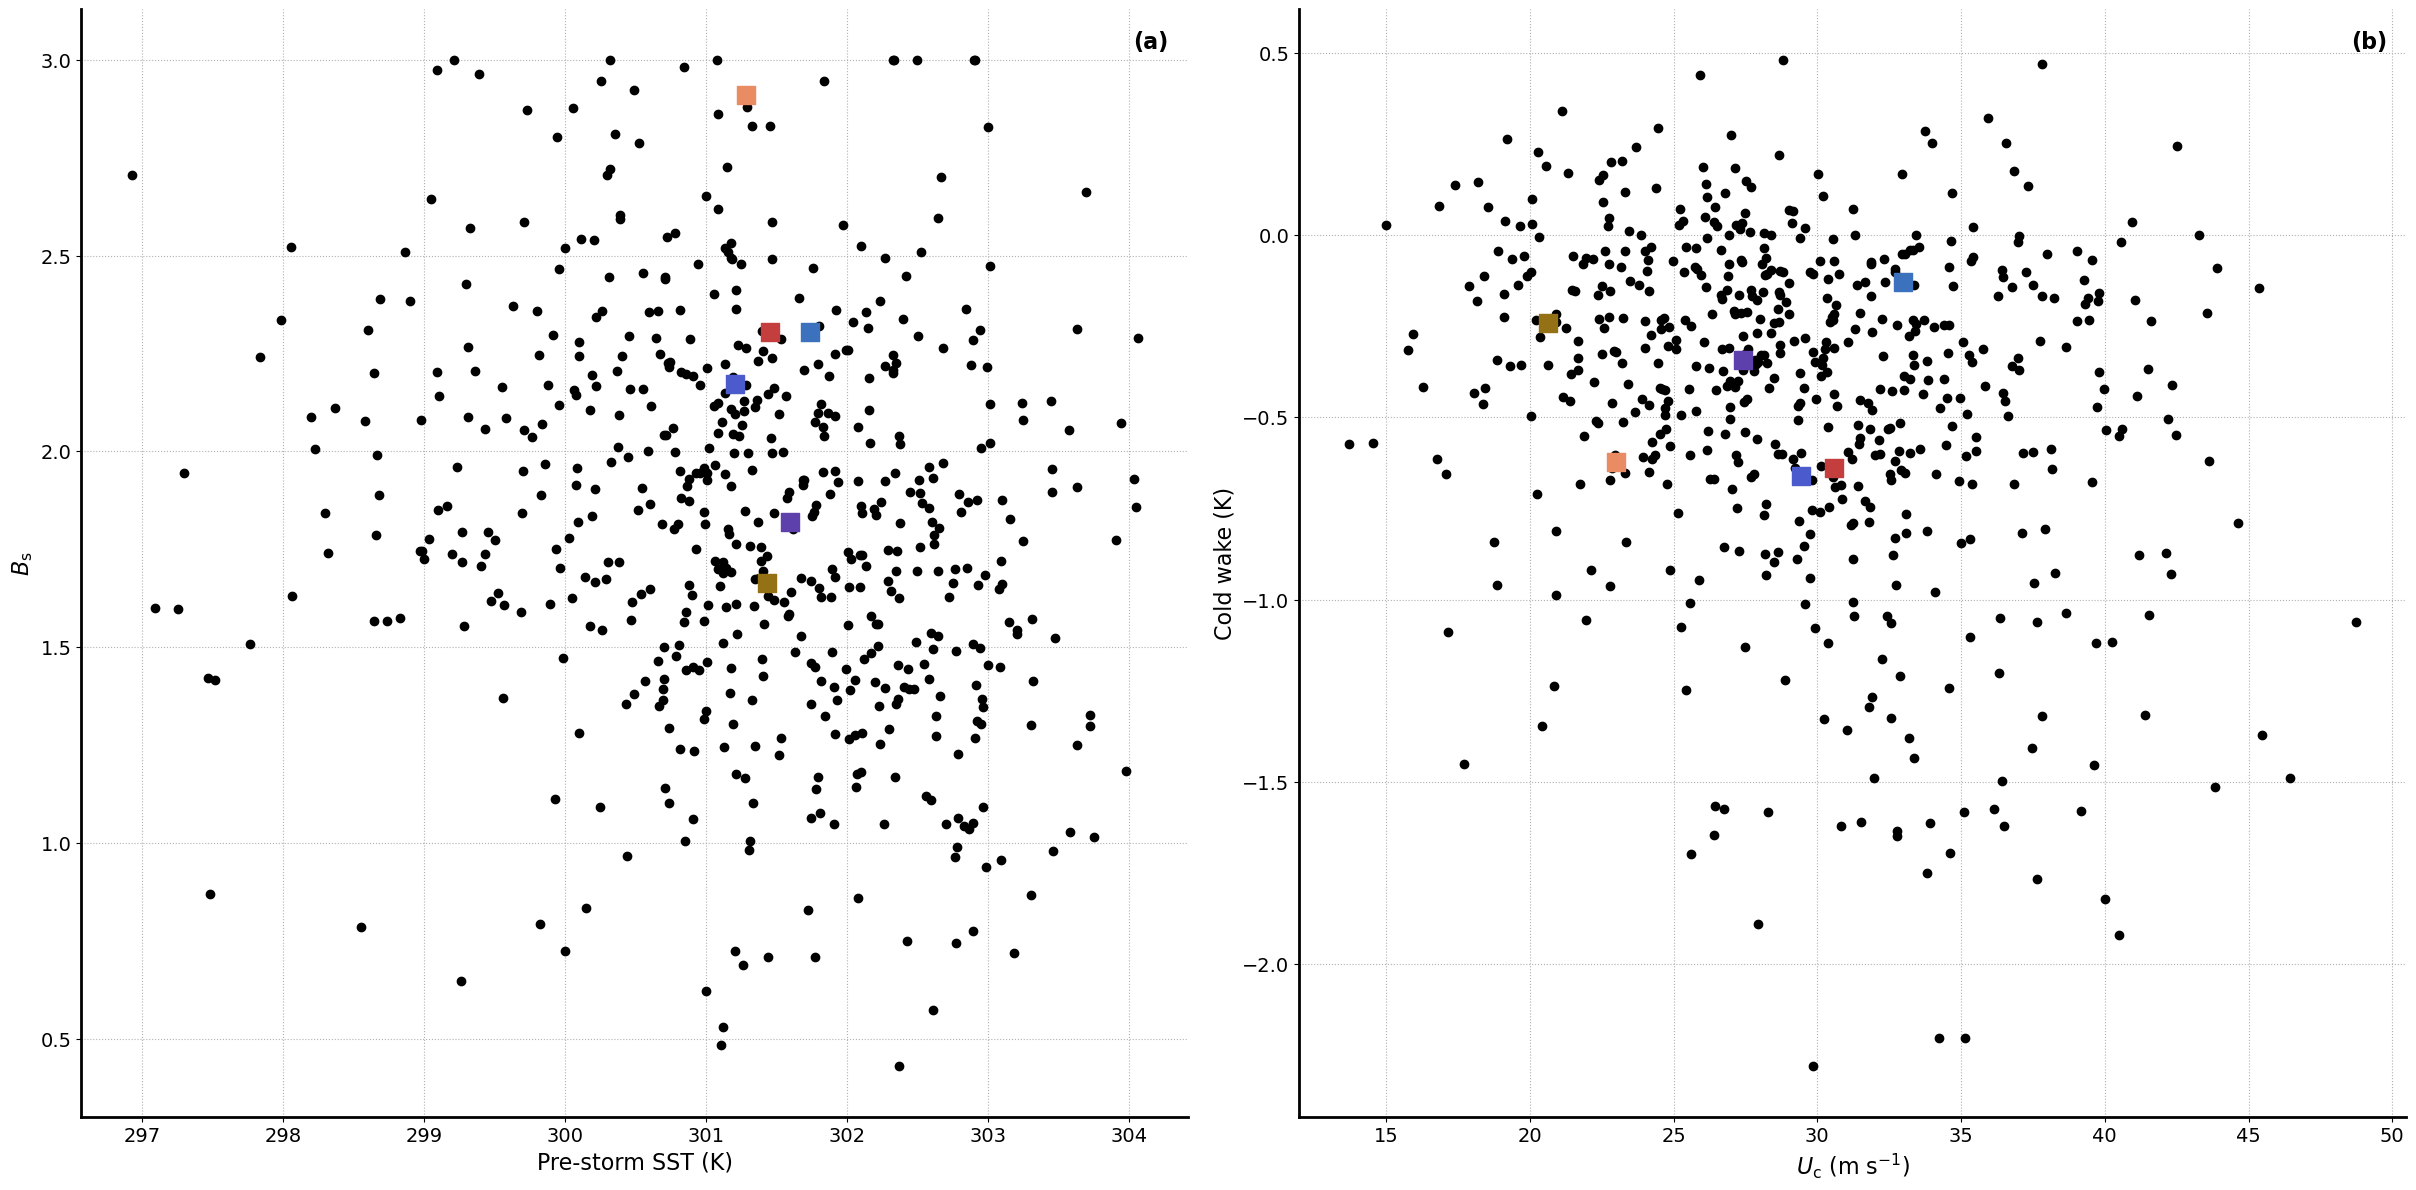

In [33]:
# Fig.
fig        = plt.figure(figsize=(30, 20))
gs         = GridSpec(1, 2, hspace=0.05, wspace=0.1, height_ratios=[1])

############
###  Bs  ###
############
ax = fig.add_subplot(gs[0, 0])
ax.text(0.95, 0.965, '(a)', transform=ax.transAxes, weight='bold')

# All
ax.scatter(d.pre_sst_rms, d.B_hol, color='k')
# Chido
for t in range(len(ds.time)):
    ax.scatter(ds.isel(time=t).pre_sst_rms, ds.isel(time=t).B_hol, color=cmap(norm(ds.isel(time=t).t_since_lmi_ibt / 3600)), s=150, marker='s')

# Labels
ax.set_xlabel('Pre-storm SST (K)')
ax.set_ylabel(r'$B_{\text{s}}$')
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['bottom'].set_linewidth(2)
ax.spines[['right', 'top']].set_visible(False)
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background
ax.set_box_aspect(1)


############
###  Uc  ###
############
ax = fig.add_subplot(gs[0, 1])
ax.text(0.95, 0.965, '(b)', transform=ax.transAxes, weight='bold')

# All
ax.scatter(d.uc, d.cod_wak_rms, color='k')
# Chido
for t in range(len(ds.time)):
    ax.scatter(ds.isel(time=t).uc, ds.isel(time=t).cod_wak_rms, color=cmap(norm(ds.isel(time=t).t_since_lmi_ibt / 3600)), s=150, marker='s')

# Labels
ax.set_xlabel(r'$U_{\text{c}}$ (m s$^{-1}$)')
ax.set_ylabel(r'Cold wake (K)')
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['bottom'].set_linewidth(2)
ax.spines[['right', 'top']].set_visible(False)
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background
ax.set_box_aspect(1)

# # Save
# plt.savefig(PTHS['sav_dir'] + 'chido_ocean.png', bbox_inches='tight')

### Comparison with Freddy

In [34]:
### Choose ID
atcf_id = 'sh112023'
# Choose time period
# For Freddy, we cut the second part of the life cycle
t_lim1 = -4 * 72
t_lim2 = 1

In [35]:
# import matplotlib.colors as mcolors
# import numpy as np # Import numpy for potential numerical operations if needed

# Définition des limites de la nouvelle plage totale
# Nouveau vmin est -4 * 72 = -288
vmin_new = -4 * 72
vmax_new = 0 # La nouvelle plage va jusqu'à 0

# Couleurs existantes pour la partie négative
color_neg_72 = 'black'
color_neg_48 = 'goldenrod'
color_neg_24 = 'lightcoral'
color_zero_neg_side = 'firebrick'

# Fonction utilitaire pour normaliser une valeur sur la nouvelle plage
def normalize_value_new(val, vmin, vmax):
    return (val - vmin) / (vmax - vmin)


# Appliquons ces proportions à la nouvelle plage [-288, 0]:
new_cmap_points = [
    (normalize_value_new(vmin_new, vmin_new, vmax_new), color_neg_72), # black at -288 (0 in new normalization)
    (normalize_value_new(-4 * 48, vmin_new, vmax_new), color_neg_48), # goldenrod at -192 (1/3 of the way from -288 to 0)
    (normalize_value_new(-4 * 24, vmin_new, vmax_new), color_neg_24), # lightcoral at -96 (2/3 of the way from -288 to 0)
    (normalize_value_new(vmax_new, vmin_new, vmax_new), color_zero_neg_side) # firebrick at 0 (1 in new normalization)
]

cmap_neg_only = mcolors.LinearSegmentedColormap.from_list("custom_neg_only_cmap", new_cmap_points)

# Pour la normalisation, une simple LinearNormalization est suffisante car il n'y a pas de centre à pivoter
norm_neg_only = mcolors.Normalize(vmin=vmin_new, vmax=vmax_new)

print("New colormap 'cmap_neg_only' and normalization 'norm_neg_only' have been created.")

New colormap 'cmap_neg_only' and normalization 'norm_neg_only' have been created.


In [36]:
### Select case
# SAR
ds  = d.where(d.id == atcf_id, drop=True)
# BTK
dsi = ds_ibt.where(ds_ibt.usa_atcf_id == atcf_id.upper(), drop=True).isel(storm=0)
dsi = dsi.where(((dsi.t_since_lmi / 3600) >= t_lim1) & ((dsi.t_since_lmi / 3600) <= t_lim2), drop=True)

In [37]:
# A23 and other parameters
# Basics
dsi['vmx_reg'] = correct_vmx_ibt(dsi['usa_wind'])
dsi['fcr']     = abs(coriolis(dsi['usa_lat']))

# Rmax A23
# Compute the momentum ratios
Mm_M34 = 0.531 * np.exp(
    -0.00214 * (dsi['vmx_reg'] - 17.5)
    -0.00314 * (dsi['vmx_reg'] - 17.5) * 0.5 * dsi['fcr'] * dsi['mean_r34']
)
Mm_M50 = 0.626 * np.exp(
     0.00282 * (dsi['vmx_reg'] - 25.7)
    -0.00724 * (dsi['vmx_reg'] - 25.7) * 0.5 * dsi['fcr'] * dsi['mean_r50']
)
Mm_M64 = 0.612 * np.exp(
     0.00946 * (dsi['vmx_reg'] - 32.9)
    -0.01183 * (dsi['vmx_reg'] - 32.9) * 0.5 * dsi['fcr'] * dsi['mean_r64']
)
# Compute Mmax
Mm_with_r34 = Mm_M34 * M(dsi['fcr'], dsi['mean_r34'], 17.5)
Mm_with_r50 = Mm_M50 * M(dsi['fcr'], dsi['mean_r50'], 25.7)
Mm_with_r64 = Mm_M64 * M(dsi['fcr'], dsi['mean_r64'], 32.9)
# Compute Rmax_CK22A23
Rm_with_r34 = Rmax_from_M(dsi['fcr'], Mm_with_r34, dsi['vmx_reg'])
Rm_with_r50 = Rmax_from_M(dsi['fcr'], Mm_with_r50, dsi['vmx_reg'])
Rm_with_r64 = Rmax_from_M(dsi['fcr'], Mm_with_r64, dsi['vmx_reg'])
# Assign to your dataset
dsi['new_rmx'] = Rm_with_r34.copy(deep=True)
dsi['new_rmx'][Rm_with_r50.notnull()] = Rm_with_r50.copy(deep=True)[Rm_with_r50.notnull()]
dsi['new_rmx'][Rm_with_r64.notnull()] = Rm_with_r64.copy(deep=True)[Rm_with_r64.notnull()]

# Others
dsi['rsb']     = dsi['usa_wind'] / (abs(dsi['fcr']) * dsi['usa_rmw'])
dsi['r0']      = np.sqrt(2 * dsi['rsb']) * dsi['usa_rmw']
dsi['new_rsb'] = dsi['vmx_reg'] / (abs(dsi['fcr']) * dsi['new_rmx'])
dsi['new_r0']  = np.sqrt(2 * dsi['new_rsb']) * dsi['new_rmx']

In [38]:
### Add Bs, Uc, and R+

  0%|          | 0/97 [00:00<?, ?it/s]

/tmp/ipykernel_29802/1666442556.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(


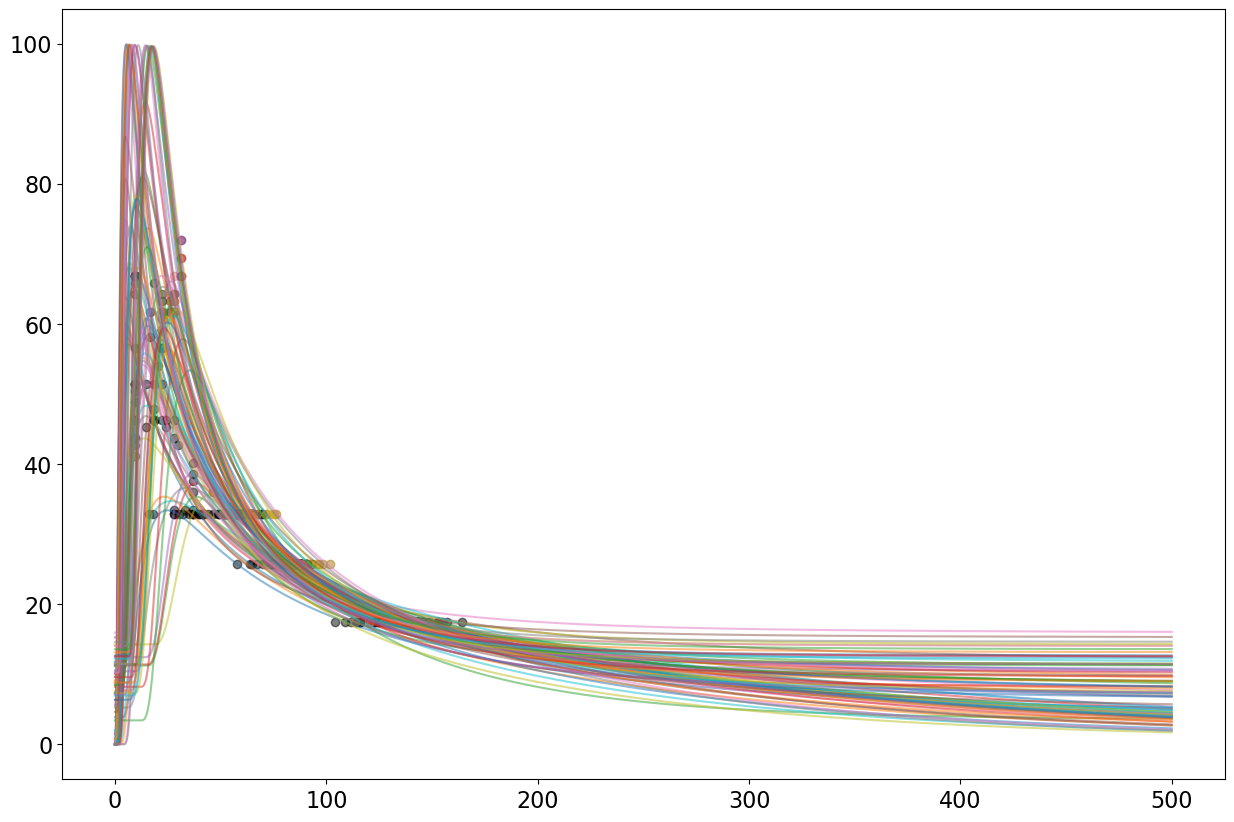

In [39]:
# Add Bs 
# Adjusts a Holland wind profile to BTK wind radii
# Only when both r34, r50 and r64 are defined to ensure minimum number of valid points
# Fitting results look bad
# NB: I tried to enforce Vmin = 10m/s (i.e average SAR ds.vmin.mean()), but this doesn't improve fittings

Bs   = []
VMNs = []
RMXs = []
VMXs = []

for dtm in tqdm(range(len(dsi.date_time))):
    # Concatenate wind radii
    rss = [float(dsi.isel(date_time=dtm)['usa_rmw']), float(dsi.isel(date_time=dtm)['mean_r64']), float(dsi.isel(date_time=dtm)['mean_r50']), float(dsi.isel(date_time=dtm)['mean_r34'])]
    wss = [float(dsi.isel(date_time=dtm)['usa_wind']), 32.9, 25.7, 17.5]

    # Fit Holland
    if np.count_nonzero(np.isnan(rss)) == 0:
        # Holland
        popt, pcov = curve_fit(
            lambda r, B, Vmin, Rmax, Vmax: holland_profile(r, abs(float(dsi.isel(date_time=dtm).usa_lat)), B, Vmin, Rmax, Vmax),
            # lambda r, B, Rmax, Vmax: holland_profile(r, float(dsi.isel(date_time=d).usa_lat), B, 10, Rmax, Vmax),
            np.array(rss), 
            np.array(wss), 
            p0=[1.8, 5, 20 * 1000, 40], 
            # p0=[1.8, 20 * 1000, 40],
            bounds=(
                tuple([BDS_HOL[e][0] for e in BDS_HOL.keys()]), # NB: lat is fixed
                tuple([BDS_HOL[e][1] for e in BDS_HOL.keys()])
            ) 
        ) 
        B_hol, vmn_hol, rmx_hol, vmx_hol = popt
        # B_hol, rmx_hol, vmx_hol = popt
        # Plot
        plt.scatter(np.array(rss) / 1000, wss, color=cmap(norm(float(dsi.isel(date_time=dtm).t_since_lmi / 3600))), alpha=0.5)
        plt.plot(np.linspace(0, 500000, 1001) / 1000, holland_profile(np.linspace(0, 500000, 1001), float(dsi.isel(date_time=dtm).usa_lat), B_hol, vmn_hol, rmx_hol, vmx_hol), alpha=0.5)
        # plt.plot(np.linspace(0, 500000, 1001) / 1000, holland_profile(np.linspace(0, 500000, 1001), float(dsi.isel(date_time=dtm).usa_lat), B_hol, 10, rmx_hol, vmx_hol), alpha=0.5)
    else:
        B_hol = vmn_hol = rmx_hol = vmx_hol = np.nan
        # B_hol = rmx_hol = vmx_hol = np.nan
    # Append
    Bs.append(B_hol)
    VMNs.append(vmn_hol)
    RMXs.append(rmx_hol)
    VMXs.append(vmx_hol)
    
# plt.xlim(0, 250)
dsi['Bs']     = xr.DataArray(Bs, dims='date_time')
dsi['uc']     = np.sqrt(3 * np.sqrt(2) * dsi.usa_wind ** 2 / np.sqrt(dsi.Bs * dsi.rsb))
dsi['new_uc'] = np.sqrt(3 * np.sqrt(2) * dsi.vmx_reg ** 2 / np.sqrt(dsi.Bs * dsi.new_rsb))

In [40]:
ds.isel(time=0).t_lmi_ibt

<xarray.DataArray 't_lmi_ibt' ()> Size: 8B
array('2023-02-19T18:00:00.000039936', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2023-02-08T22:12:23
Attributes:
    long_name:  Time of the lifetime maximum intensity from IBTrACS (U.S. Age...

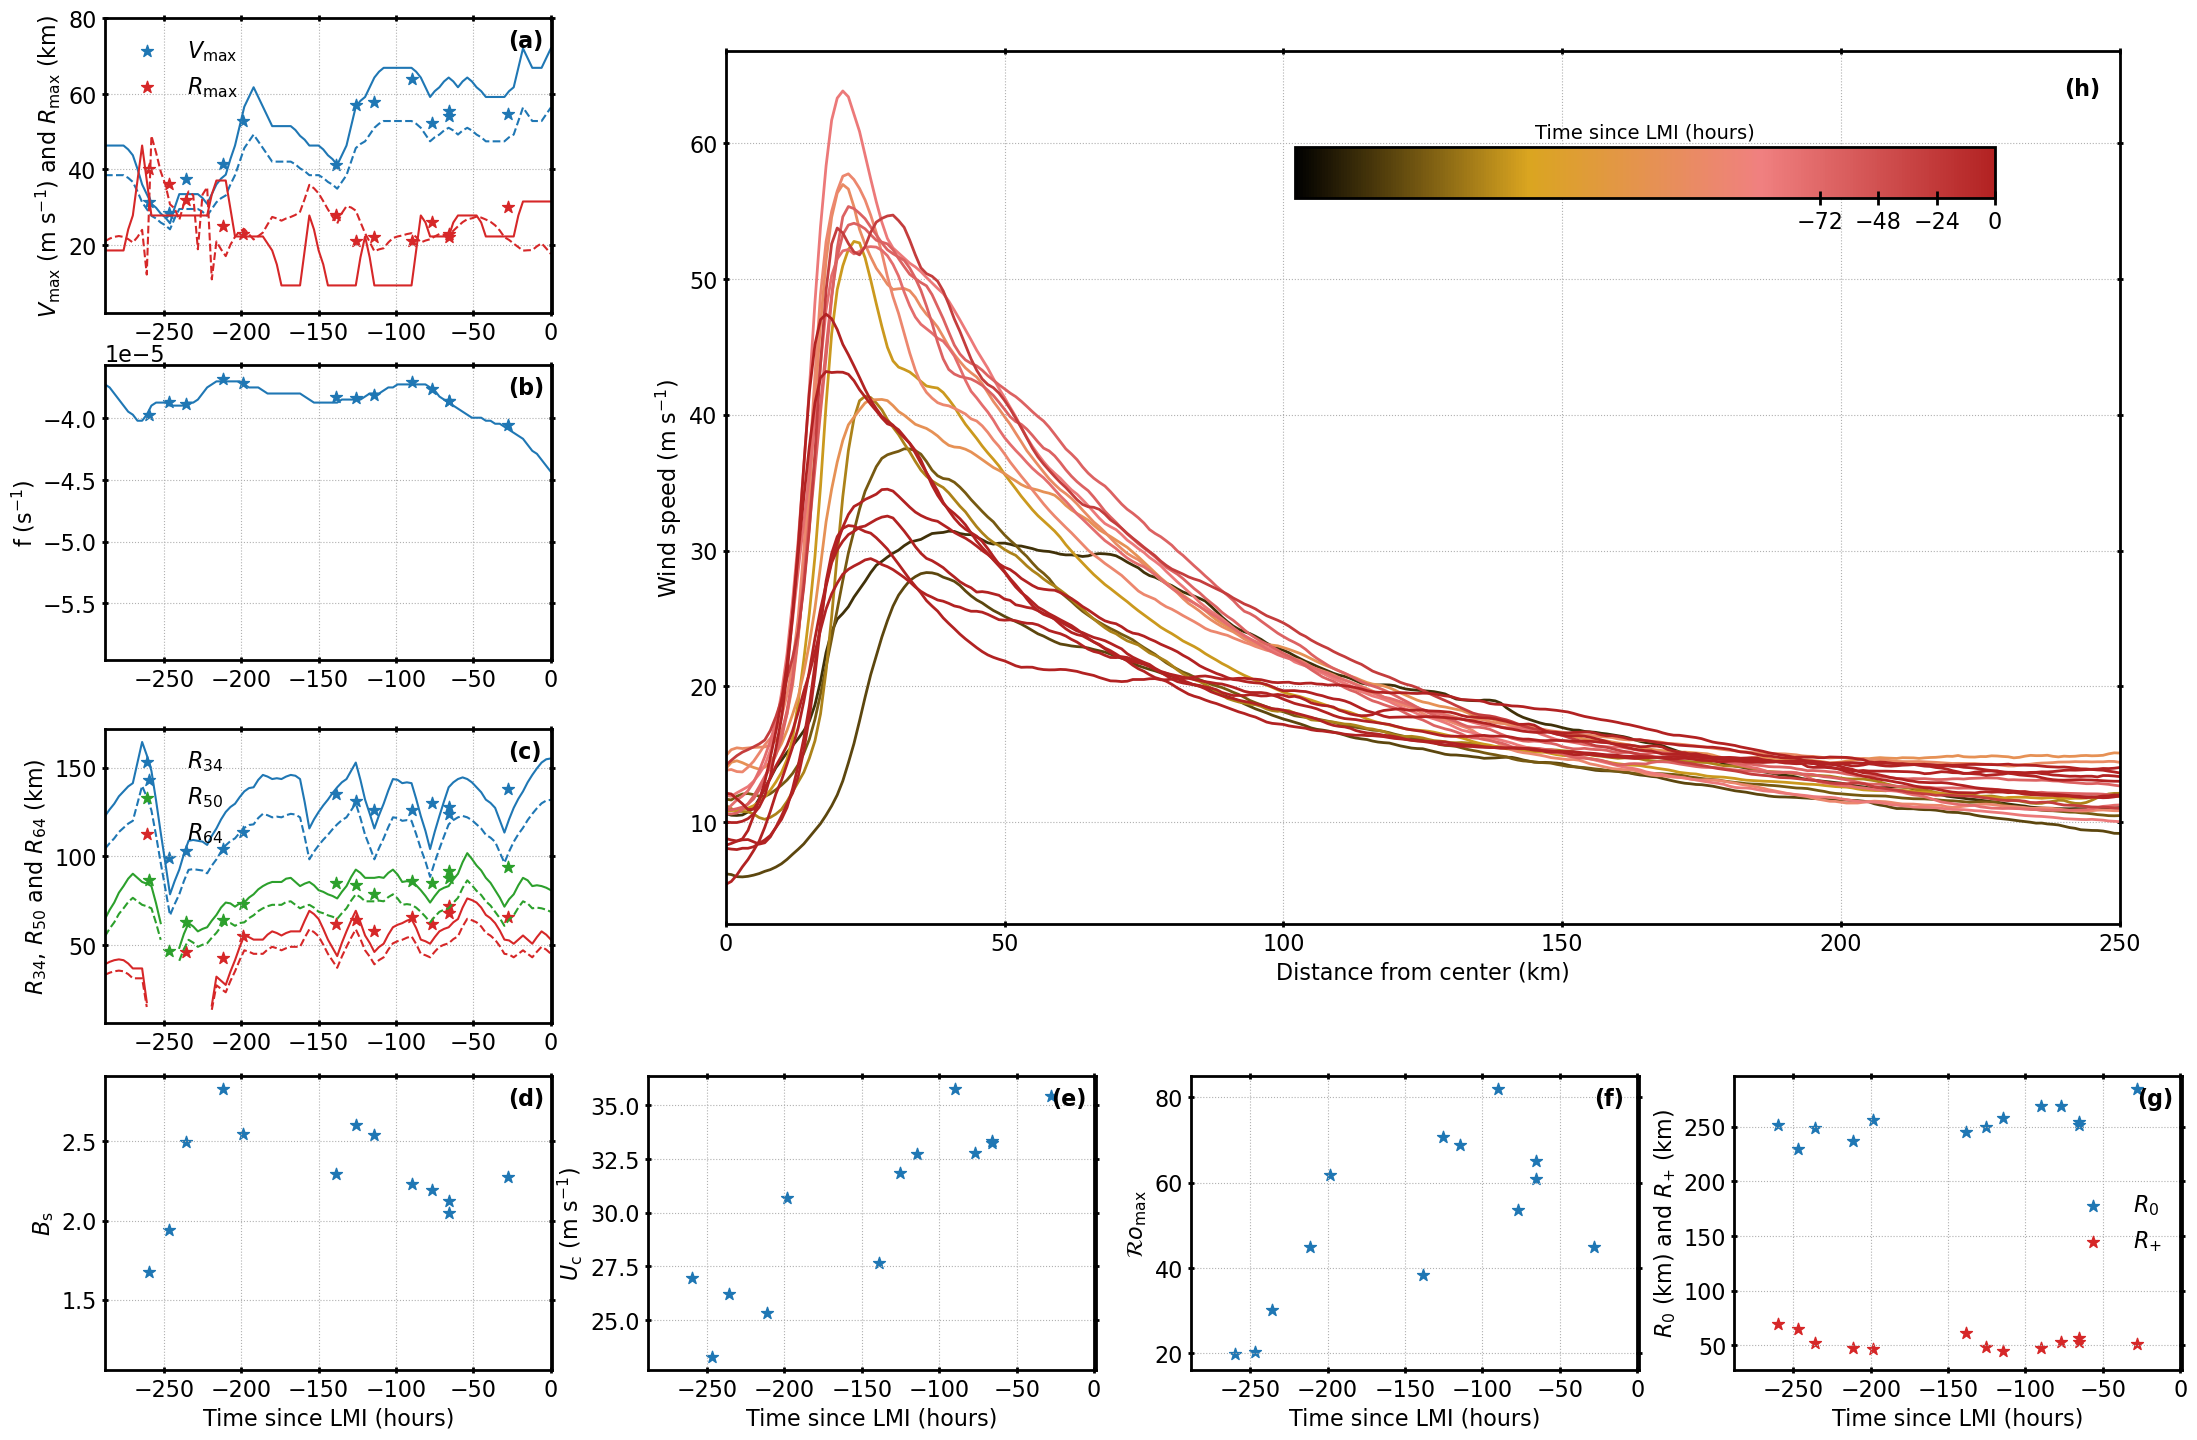

In [42]:
### Hyperparameters
ticks  = np.arange(-72, 73, 24)
ax_lim = 250

fig = plt.figure(figsize = (28, 30))

# Define the number of division, 1st vertical 2nd horizontal
# It's convenient to put a large number of division to perform smart tuning of the subplot position
gs  = GridSpec(140, 140) 

################
### PROFILES ###
################
ax = fig.add_subplot(gs[2:55, 40:130])
ax.text(0.96, 0.95, '(h)', transform=ax.transAxes, weight='bold')

for t in range(len(ds.time)):
    # Open
    dss = ds.isel(time=t)
    dsp = xr.open_dataset(PTHS['sar_dir'] + dss.file_tcva.item()).isel(time=0)
    wsm = dsp.wind_speed.mean(dim='theta')

    # Plot
    ax.plot(wsm.rad / 1000, wsm, c=cmap_neg_only(norm_neg_only(dss.t_since_lmi_ibt / 3600)), linewidth=2)

    # Close
    dsp.close()

# Axes
ax.set_xlim(0, ax_lim)
ax.set_ylabel(r'Wind speed (m s$^{-1}$)')
ax.set_xlabel(r'Distance from center (km)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

# Colorbar
sm   = plt.cm.ScalarMappable(cmap=cmap_neg_only, norm=norm_neg_only)
sm.set_array([])
cbar_ax = fig.add_axes([0.55, 0.82, 0.25, 0.017]) # Position of the colorbar (this is tricky just do tests)
cbar    = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', ticks=ticks)
cbar_ax.set_title(r'Time since LMI (hours)', fontsize=fontsize-2, x=0.5, y=1.02)
cbar.ax.yaxis.set_offset_position('right')
cbar.update_ticks()
cbar.outline.set_linewidth(2)
cbar_ax.tick_params(direction='inout', width=2, length=10, labelsize=16)

################
### RMX/VMX  ###
################
ax = fig.add_subplot(gs[:18, :29])
ax.text(0.9, 0.9, '(a)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.vmx,        marker='*', s=80, color='tab:blue', label=r'$V_{\text{max}}$')
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.rmx / 1000, marker='*', s=80, color='tab:red',  label=r'$R_{\text{max}}$')
# BTK
ax.plot(dsi.t_since_lmi / 3600,       dsi.usa_wind,                    color='tab:blue')
ax.plot(dsi.t_since_lmi / 3600,       dsi.vmx_reg,                     color='tab:blue', linestyle='dashed')
ax.plot(dsi.t_since_lmi / 3600,       dsi.usa_rmw / 1000,              color='tab:red')
ax.plot(dsi.t_since_lmi / 3600,       dsi.new_rmx / 1000,              color='tab:red', linestyle='dashed')
ax.set_ylim(2, 80)

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(t_lim1, t_lim2)
ax.set_ylabel(r'$V_{\text{max}}$ (m s$^{-1}$) and $R_{\text{max}}$ (km)')
# ax.set_xlabel(r'Time since LMI (hours)')
ax.legend(frameon=False)

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###   FCOR   ###
################
ax = fig.add_subplot(gs[21:39, :29])
ax.text(0.9, 0.9, '(b)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.fcor,        marker='*', s=80, color='tab:blue')
# BTK
ax.plot(dsi.t_since_lmi / 3600,       -dsi.fcr,                          color='tab:blue')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(t_lim1, t_lim2)
ax.set_ylabel(r'f (s$^{-1})$')
# ax.set_xlabel(r'Time since LMI (hours)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###   Rxx    ###
################
ax = fig.add_subplot(gs[43:61, :29])
ax.text(0.9, 0.9, '(c)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.r34 / 1000, marker='*', s=80, color='tab:blue',  label=r'$R_{\text{34}}$')
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.r50 / 1000, marker='*', s=80, color='tab:green', label=r'$R_{\text{50}}$')
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.r64 / 1000, marker='*', s=80, color='tab:red',   label=r'$R_{\text{64}}$')
# BTK
ax.plot(dsi.t_since_lmi / 3600,       dsi.mean_r34 / 1000,             color='tab:blue')
ax.plot(dsi.t_since_lmi / 3600,       dsi.mean_r50 / 1000,             color='tab:green')
ax.plot(dsi.t_since_lmi / 3600,       dsi.mean_r64 / 1000,             color='tab:red')
ax.plot(dsi.t_since_lmi / 3600,       0.85 * dsi.mean_r34 / 1000,      color='tab:blue',  linestyle='dashed',)
ax.plot(dsi.t_since_lmi / 3600,       0.85 * dsi.mean_r50 / 1000,      color='tab:green', linestyle='dashed',)
ax.plot(dsi.t_since_lmi / 3600,       0.85 * dsi.mean_r64 / 1000,      color='tab:red',   linestyle='dashed',)


# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(t_lim1, t_lim2)
ax.set_ylabel(r'$R_{\text{34}}$, $R_{\text{50}}$ and $R_{\text{64}}$ (km)')
# ax.set_xlabel(r'Time since LMI (hours)')
ax.legend(frameon=False)

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###    Bs    ###
################
ax = fig.add_subplot(gs[64:82, :29])
ax.text(0.9, 0.9, '(d)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.B_hol, marker='*', s=80, color='tab:blue')
# # BTK
# ax.plot(dsi.t_since_lmi / 3600,    dsi.Bs,                        color='tab:blue')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(t_lim1, t_lim2)
ax.set_ylabel(r'$B_{\text{s}}$')
ax.set_xlabel(r'Time since LMI (hours)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###    Uc    ###
################
ax = fig.add_subplot(gs[64:82, 35:64])
ax.text(0.9, 0.9, '(e)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.uc, marker='*', s=80, color='tab:blue')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(t_lim1, t_lim2)
ax.set_ylabel(r'$U_{\text{c}}$ (m s$^{-1}$)')
ax.set_xlabel(r'Time since LMI (hours)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###  Rossby  ###
################
ax = fig.add_subplot(gs[64:82, 70:99])
ax.text(0.9, 0.9, '(f)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.rsby, marker='*', s=80, color='tab:blue')
# # BTK
# ax.plot(dsi.t_since_lmi / 3600,       dsi.rsb,                   color='tab:blue')
# ax.plot(dsi.t_since_lmi / 3600,       dsi.new_rsb,               color='tab:blue', linestyle='dashed')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(t_lim1, t_lim2)
ax.set_ylabel(r'$\mathcal{R}o_{\text{max}}$')
ax.set_xlabel(r'Time since LMI (hours)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###  R+/R0   ###
################
ax = fig.add_subplot(gs[64:82, 105:134])
ax.text(0.9, 0.9, '(g)', transform=ax.transAxes, weight='bold')

# Plot
# SAR
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.r0 / 1000,  marker='*', s=80, color='tab:blue', label=r'$R_{\text{0}}$')
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.rps / 1000, marker='*', s=80, color='tab:red',  label=r'$R_{\text{+}}$')
# # BTK
# ax.plot(dsi.t_since_lmi / 3600,       dsi.r0 / 1000,                   color='tab:blue')
# ax.plot(dsi.t_since_lmi / 3600,       dsi.new_r0 / 1000,               color='tab:blue', linestyle='dashed')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(t_lim1, t_lim2)
ax.set_ylabel(r'$R_{\text{0}}$ (km) and $R_{\text{+}}$ (km)')
ax.set_xlabel(r'Time since LMI (hours)')
ax.legend(frameon=False)

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

# # Save
# plt.savefig(PTHS['sav_dir'] + 'freddy_winds.png', bbox_inches='tight')

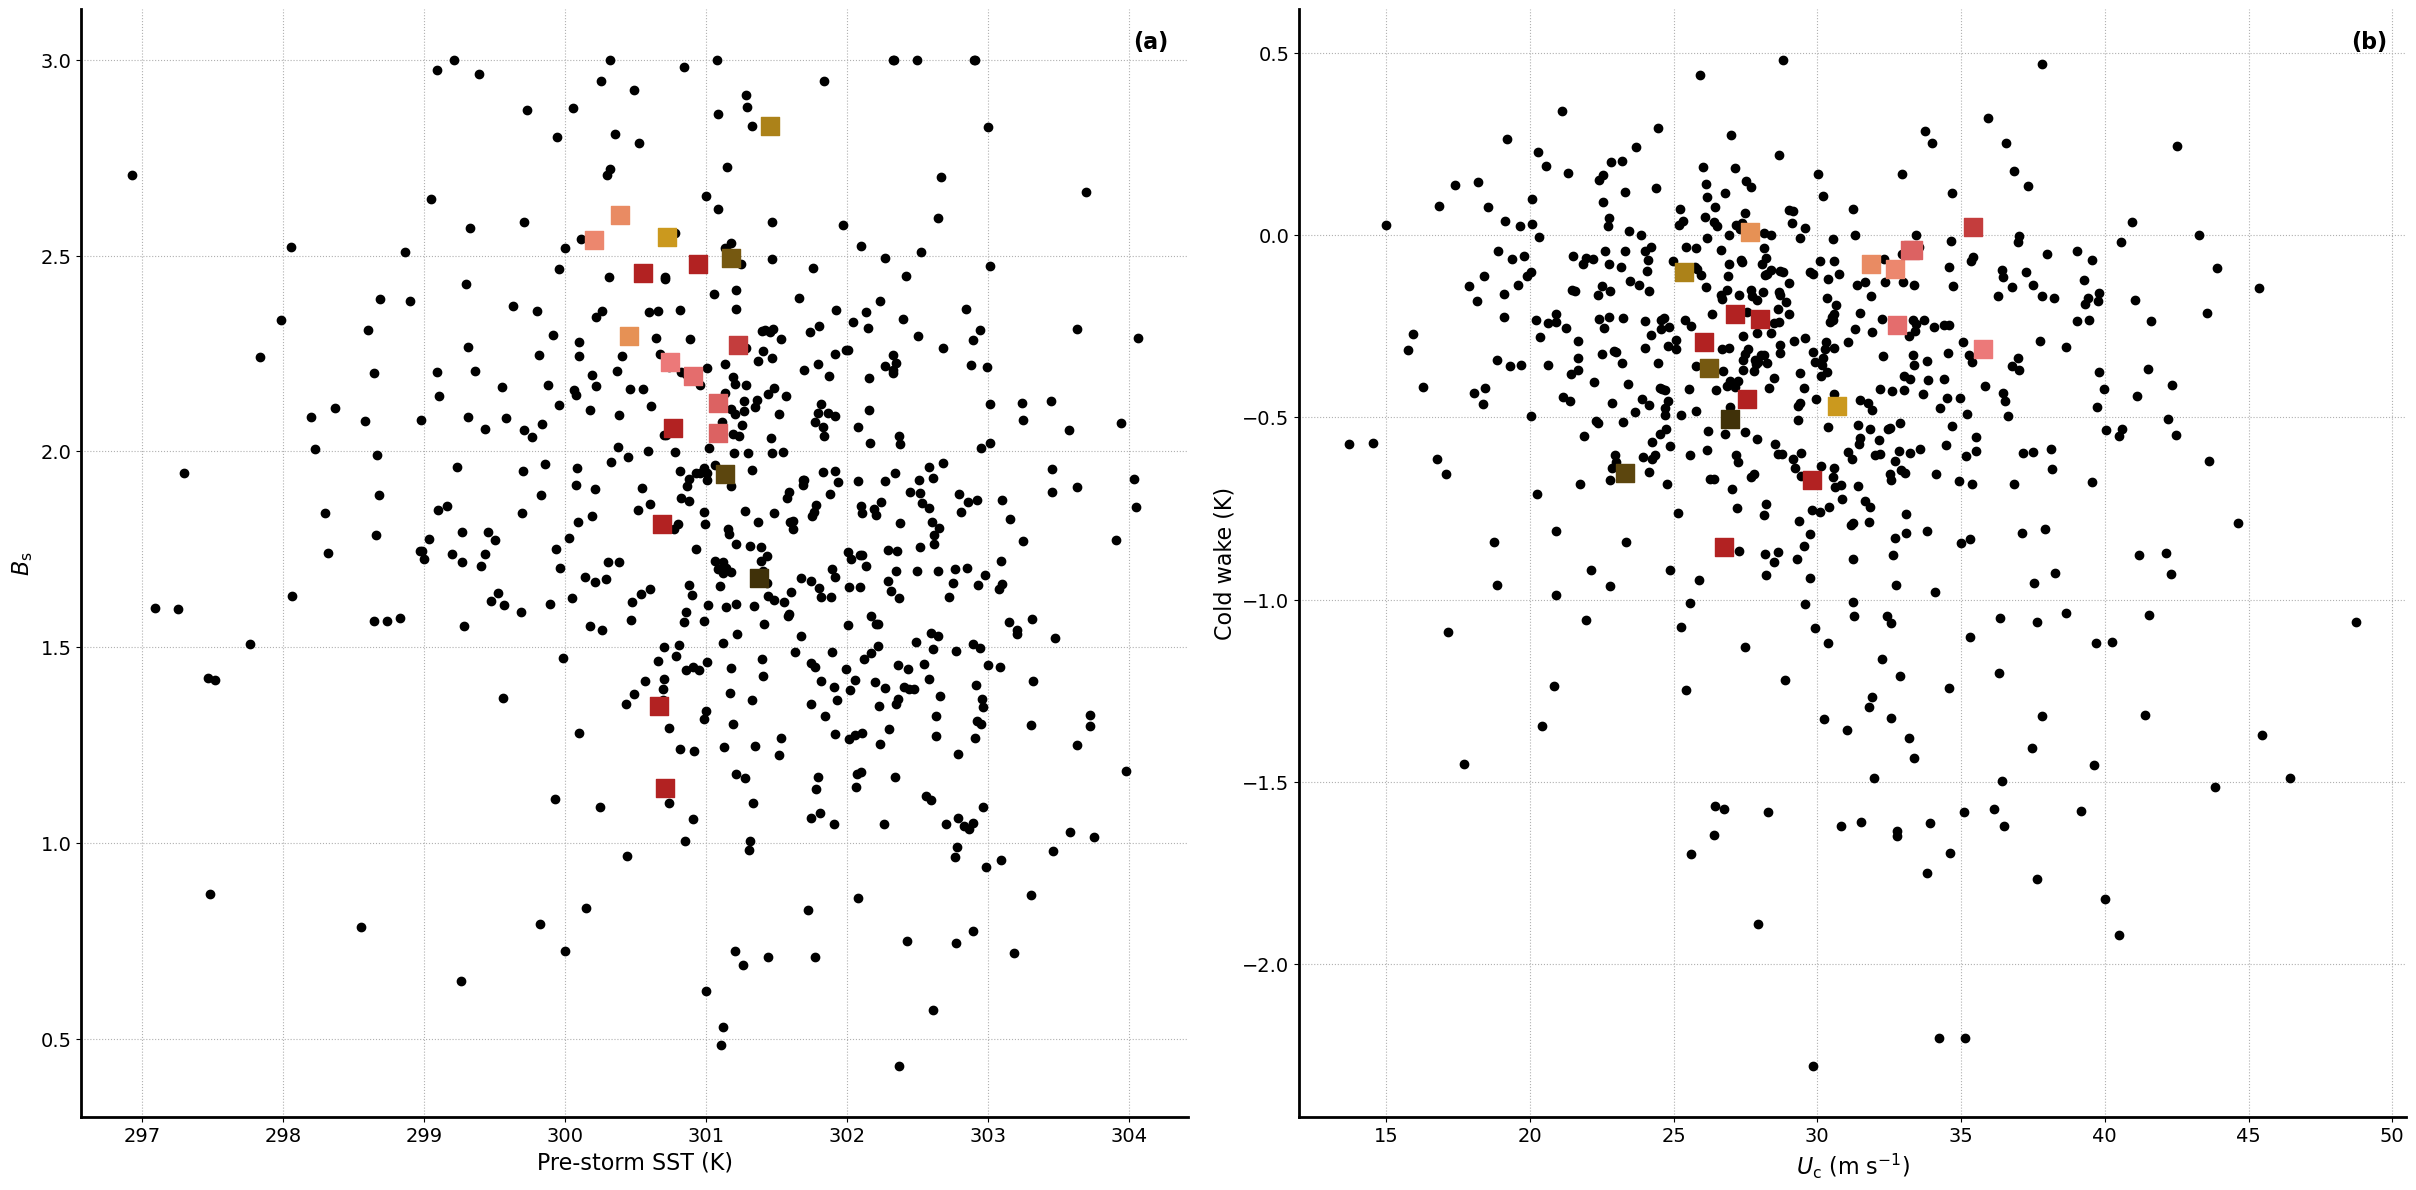

In [47]:
# Fig.
fig        = plt.figure(figsize=(30, 20))
gs         = GridSpec(1, 2, hspace=0.05, wspace=0.1, height_ratios=[1])

############
###  Bs  ###
############
ax = fig.add_subplot(gs[0, 0])
ax.text(0.95, 0.965, '(a)', transform=ax.transAxes, weight='bold')

# All
ax.scatter(d.pre_sst_rms, d.B_hol, color='k')
# Chido
for t in range(len(ds.time)):
    ax.scatter(ds.isel(time=t).pre_sst_rms, ds.isel(time=t).B_hol, color=cmap_neg_only(norm_neg_only(ds.isel(time=t).t_since_lmi_ibt / 3600)), s=150, marker='s')

# Labels
ax.set_xlabel('Pre-storm SST (K)')
ax.set_ylabel(r'$B_{\text{s}}$')
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['bottom'].set_linewidth(2)
ax.spines[['right', 'top']].set_visible(False)
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background
ax.set_box_aspect(1)


############
###  Uc  ###
############
ax = fig.add_subplot(gs[0, 1])
ax.text(0.95, 0.965, '(b)', transform=ax.transAxes, weight='bold')

# All
ax.scatter(d.uc, d.cod_wak_rms, color='k')
# Chido
for t in range(len(ds.time)):
    ax.scatter(ds.isel(time=t).uc, ds.isel(time=t).cod_wak_rms, color=cmap_neg_only(norm_neg_only(ds.isel(time=t).t_since_lmi_ibt / 3600)), s=150, marker='s')

# Labels
ax.set_xlabel(r'$U_{\text{c}}$ (m s$^{-1}$)')
ax.set_ylabel(r'Cold wake (K)')
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['bottom'].set_linewidth(2)
ax.spines[['right', 'top']].set_visible(False)
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background
ax.set_box_aspect(1)

# # Save
# plt.savefig(PTHS['sav_dir'] + 'freddy_ocean.png', bbox_inches='tight')